## Importing Libraries

In [1]:
# General imports
import math
import numpy as np
import pandas as pd
import joblib

# Text Preprocessing imports
import nltk
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter

# General preprocessing imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# Visualization imports
import matplotlib.pyplot as plt
import pylab as plot
import seaborn as sns
sns.set(style="white")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
#Setting the figure size for all plots: https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
%matplotlib inline

params = {'figure.figsize' : (16, 9),
          'legend.fontsize': 16,
          'legend.handlelength': 2,
          'axes.titlesize' : 'large'}
plot.rcParams.update(params)

### Importing the data

In [4]:
df_train = pd.read_csv('train.tsv', sep='\t')

### Train-Cross Validation Split

In [5]:
df_train, df_cv = train_test_split(df_train, test_size = 0.25, random_state = 21)

In [6]:
print(df_train.shape)
print(df_cv.shape)

(1111901, 8)
(370634, 8)


### Applying log transform to the price variable

In [7]:
df_train['price_log'] = np.log1p(df_train['price'])
df_cv['price_log'] = np.log1p(df_cv['price'])

## 4. Data Preprocessing

### 4.1 Handling Null values

In [8]:
df_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          4704
brand_name           474625
price                     0
shipping                  0
item_description          2
price_log                 0
dtype: int64

In [9]:
df_train.fillna('', inplace=True)
df_cv.fillna('', inplace=True)

#### No Description Yet in Title is also a kind of NaN value only and hence should be converted to empty string too

In [10]:
#Convert No description yet to ''
df_train['item_description']  = df_train['item_description'].str.replace('^no description yet$', '', regex=True)
df_cv['item_description']     = df_cv['item_description'].str.replace('^no description yet$', '', regex=True)

### 4.2 Cleaning rows with invalid prices
Mercari platform only allows price listing between 3 and 2000 and hence we should remove the rows which do not have price in this range

In [11]:
df_train = df_train[(df_train['price'] >= 3) & (df_train['price'] <= 2000)]
df_cv    = df_cv[(df_cv['price'] >= 3) & (df_cv['price'] <= 2000)]

### 4.3 Join Brand Name, Item Name and Description Together
This idea is inspired from the Winners' solution to this problem: https://www.kaggle.com/c/mercari-price-suggestion-challenge/discussion/50256

The objective behind this was to vectorize all of the text together so as to limit the number of features while using Bag of Words/TF-IDF vectorization

In [12]:
df_train['name'] = df_train['name'] + " " + df_train['brand_name']
df_train['text'] = df_train['item_description'] + " " + df_train['name'] + " " + df_train['category_name']

df_cv['name'] = df_cv['name'] + " " + df_cv['brand_name']
df_cv['text'] = df_cv['item_description'] + " " + df_cv['name'] + " " + df_cv['category_name']

### 4.4 Cleaning Text Data

In [13]:
# Ref: AAIC Notebook for Donors' Choose
def decontracted(sent):
    '''
    Task:   This Function changes common short forms like can't, won't to can not, will not resp. (Decontraction)
            This is done to ensure uniformity in the whole text
    Input:  Raw Text
    Output: Decontracted Text
    '''
    sent = re.sub(r"aren\'t", "are not", sent)
    sent = re.sub(r"didn\'t", "did not", sent)
    sent = re.sub(r"can\'t", "can not", sent)
    sent = re.sub(r"couldn\'t", "could not", sent)
    sent = re.sub(r"won\'t", "would not", sent)
    sent = re.sub(r"wouldn\'t", "would not", sent)
    sent = re.sub(r"haven\'t", "have not", sent)
    sent = re.sub(r"shouldn\'t", "should not", sent)
    sent = re.sub(r"doesn\'t", "does not", sent)
    sent = re.sub(r"don\'t", "do not", sent)
    sent = re.sub(r"didn\'t", "did not", sent)
    sent = re.sub(r"mustn\'t", "must not", sent)
    sent = re.sub(r"needn\'t", "need not", sent)
    
    return sent

In [14]:
df_train['name'] = df_train['name'].apply(lambda x : decontracted(x))
df_train['text'] = df_train['text'].apply(lambda x : decontracted(x))

df_cv['name'] = df_cv['name'].apply(lambda x : decontracted(x))
df_cv['text'] = df_cv['text'].apply(lambda x : decontracted(x))

In [15]:
#Defining some special regexes which would be used in the function text_preprocessing() to clean the text
regex_special_chars = re.compile('[^A-Za-z0-9.]+')
regex_decimal_digits = re.compile('(?<!\d)\.(?!\d)')
regex_white_space = re.compile(r'\s+')           
    
#Creating a slightly modified list of stopwords which does not contain "no", "nor" or "not"
stop_words = set(stopwords.words("english")) - {"no", "nor", "not"}

In [16]:
def text_preprocessing(sent):
    '''
    Input  -> Raw text (string)
    Output -> Cleaned Text (string)
    Task   -> The objective of this function is to clean the text and make it suitable for Bag of Words/TF-IDF vectorization
              This includes removal of new lines, special characters, emojis etc.
    
    '''
    #Removing special characters such as carriage return and newline character
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')

    #Removing all special characters except the period
    sent = regex_special_chars.sub(' ', sent)
    
    #Removing periods which are not either followed or preceeded by a digit
    #Ref: https://stackoverflow.com/questions/6599646/remove-decimal-point-when-not-between-two-digits
    
    sent = regex_decimal_digits.sub(' ', sent)
    
    #Converting multiple white spaces to single white space
    sent = regex_white_space.sub(' ', sent)
    
    #Removing space at starting and ending and converting to lower case
    sent = sent.strip().lower()
    
    # Lemmatizing the text: Lemmetization in NLP means to convert similar words to the same word while taking care of grammar
    sent_list = sent.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in sent_list if word not in stop_words] 
    sent = " ".join(text)
    
    return sent

In [17]:
df_train['name'] = df_train['name'].apply(lambda x : text_preprocessing(x))
df_train['text'] = df_train['text'].apply(lambda x : text_preprocessing(x))

df_cv['name'] = df_cv['name'].apply(lambda x : text_preprocessing(x))
df_cv['text'] = df_cv['text'].apply(lambda x : text_preprocessing(x))

## Feature Engineering

### 5.1 Length of combined text

In EDA, we saw that length of item description can affect the price, so, we include this as a feature

In [19]:
df_train['length_combined_text'] = df_train['text'].str.len()
df_cv['length_combined_text']    = df_cv['text'].str.len()

### 5.2 Sentiment Analysis

I feel that the sentiment of the seller which is conveyed in item description should be useful while selling a product. If the seller sounds positive, it should have a positive impact on the buyer. <br>
We'll calculate this by using two popular sentiment analysis tools: TextBlob and Vader

Ideas inspired from: https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4#:~:text=1%20%E2%80%94%20TextBlob&text=It%20is%20built%20on%20top,an%20overall%20sentence%20sentiment%20score.

#### Preprocessing item_description as sentiment analysis will be applied on it only

In [20]:
df_train['item_description_cleaned'] = df_train['item_description'].apply(lambda x : decontracted(x))
df_train['item_description_cleaned'] = df_train['item_description_cleaned'].apply(lambda x : text_preprocessing(x))

In [21]:
df_cv['item_description_cleaned'] = df_cv['item_description'].apply(lambda x : decontracted(x))
df_cv['item_description_cleaned'] = df_cv['item_description_cleaned'].apply(lambda x : text_preprocessing(x))

#### TextBlob: Cleaned Text

In [22]:
def textblob_features(text):
    '''
    Task:   This function returns the Textblob Polarity and Subjectivity Scores
            While Textblob polarity score tells us that whether the seller sounds positive/negative, the subjectivity scores
            tells us whether the description is elaborative or concise
    Input:  Item Description Text
    Output: Tuple -> (TextBlob Solarity Score, TextBlob Subjectivity Score)
    '''
    textblob_scores = TextBlob(text)
    return (textblob_scores.sentiment.polarity, textblob_scores.sentiment.subjectivity)

In [23]:
df_train['textblob_polarity_cleaned'], df_train['textblob_subjectivity_cleaned'] = \
zip(*df_train['item_description_cleaned'].apply(lambda x : textblob_features(x)))

In [24]:
df_cv['textblob_polarity_cleaned'], df_cv['textblob_subjectivity_cleaned'] = \
zip(*df_cv['item_description_cleaned'].apply(lambda x : textblob_features(x)))

#### TextBlob: Original Text

In [25]:
df_train['textblob_polarity_original'], df_train['textblob_subjectivity_original'] = \
zip(*df_train['item_description'].apply(lambda x : textblob_features(x)))

In [26]:
df_cv['textblob_polarity_original'], df_cv['textblob_subjectivity_original'] = \
zip(*df_cv['item_description'].apply(lambda x : textblob_features(x)))

#### Vader: Cleaned Text

In [27]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def vader_scores(sent):
    '''
    Task:   This function returns the Vader Polarity Scores which indicates how much does the review seem positive, negative,
            neutral and a combined score which weighs all of these
    Input:  Item Description Text
    Output: Tuple -> (Vader_negative_score, Vader_neutral_score, Vader_positive_score, Vader_combined_score)
    '''
    res = sentiment_analyzer.polarity_scores(sent)
    return (res['neg'], res['neu'], res['pos'], res['compound'])

In [28]:
df_train['neg_vader_cleaned'], df_train['neutral_vader_cleaned'], df_train['pos_vader_cleaned'],\
df_train['compound_vader_cleaned'] = zip(*df_train['item_description_cleaned'].apply(lambda x : vader_scores(x)))

In [29]:
df_cv['neg_vader_cleaned'], df_cv['neutral_vader_cleaned'], df_cv['pos_vader_cleaned'],\
df_cv['compound_vader_cleaned'] = zip(*df_cv['item_description_cleaned'].apply(lambda x : vader_scores(x)))

#### Vader: Original Text

In [30]:
df_train['neg_vader_original'], df_train['neutral_vader_original'], df_train['pos_vader_original'],\
df_train['compound_vader_original'] = zip(*df_train['item_description'].apply(lambda x : vader_scores(x)))

In [31]:
df_cv['neg_vader_original'], df_cv['neutral_vader_original'], df_cv['pos_vader_original'],\
df_cv['compound_vader_original'] = zip(*df_cv['item_description'].apply(lambda x : vader_scores(x)))

### 5.3 Price Statistics Features

Here, we find the historical price statistics (mean, median) of a group of products. <br>
The grouping is done based on the category, brand_name, shipping and item_condition of the products. <br>
The idea behind this is that prices of similar products sold in the past can be used to predict prices of new products.<br>
This similarity is measured by the grouping on specific fields as mentioned previously.

#### For training data

In [32]:
#This piece of code is inspired from this great Kaggle Kernel: https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th

STD_SIGMAS = 2

cats_stats_df = df_train.groupby(['category_name',
                                  'brand_name',
                                  'shipping',
                                  'item_condition_id']).agg({'price_log': [np.median, np.mean, np.std]})

cats_stats_df.columns = ['price_log_median', 'price_log_mean', 'price_log_std']
cats_stats_df['price_log_std'] = cats_stats_df['price_log_std'].fillna(0)
cats_stats_df['price_log_conf_variance'] = cats_stats_df['price_log_std'] / cats_stats_df['price_log_mean']
cats_stats_df['price_log_conf_variance'].fillna(0, inplace=True)
cats_stats_df['min_expected_log_price'] = (cats_stats_df['price_log_mean'] - cats_stats_df['price_log_std']*STD_SIGMAS).clip(lower=1.0)
cats_stats_df['max_expected_log_price'] = (cats_stats_df['price_log_mean'] + cats_stats_df['price_log_std']*STD_SIGMAS)

#### This dictionary is maintained so that we can save the groups and their corresponding statistics for CV/Test Data

In [33]:
df_train_groups = df_train.groupby(['category_name',
                                    'brand_name',
                                    'shipping',
                                    'item_condition_id'])

In [34]:
'''
This code does the same work as above group by and aggregation code. Along with it, it saves the group names as keys in dict.
with the corresponding prices statistics as values. This is done, so that at time of CV/Test, we can get the price_statistics
for the test datapoint in O(1) time by determining it's group
'''

group_stats_dict = {}
for name, group in df_train_groups:
    price_log_column = group['price_log']
    median = np.median(price_log_column)
    mean = np.mean(price_log_column)
    std_dev = np.std(price_log_column)
    
    try:
        coef_var = std_dev / mean
    except:
        coef_var = 0
    
    min_expected_price = (mean - std_dev*STD_SIGMAS)
    
    if min_expected_price < 1:
        min_expected_price = 1
    
    max_expected_price = (mean + std_dev*STD_SIGMAS)
    
    group_stats_dict[name] = (median,
                              mean,
                              std_dev,
                              coef_var,
                              min_expected_price,
                              max_expected_price)

#### Merging with original dataframe

In [35]:
def merge_with_cat_stats(df):
    '''
    Task:   This function merges the price statistics dataframe with the existing dataframe on the fields ->
            Cateogry, Brand, Shipping and Item Condition
    Input:  Original Training DataFrame
    Output: Merged DataFrame (Categories DF + Original DF)
    '''
    return df.merge(cats_stats_df.reset_index(),
                    how='left', 
                    on=['category_name', 'brand_name', 'shipping', 'item_condition_id']).fillna(0)

In [37]:
df_train = merge_with_cat_stats(df_train)

#### For Cross-Validation/Testing Data

In [38]:
df_cv.reset_index(inplace=True)
df_cv.drop(columns = ['index'], inplace=True)

In [39]:
#There are 6 columns, one for each price statistic feature: mean, median, std_dev, coef_var, min_exp_price and max_exp_price
results_array = np.zeros((len(df_cv), 6))

In [40]:
success_counter = 0

In [41]:
'''
Following code gets the price statistics for the CV/Test datapoint from the group_stats_dict created at training time
If the exact group is not present, the price statistics remain 0
The success rate is also printed at the end of all iterations
'''
for index, row in df_cv.iterrows():
    group_name = (row['category_name'], row['brand_name'], row['shipping'], row['item_condition_id'])
    stats_tuple = group_stats_dict.get(group_name)
    if stats_tuple:
        results_array[index] = stats_tuple
        success_counter += 1
print("Success percentage = ", success_counter/len(df_cv)*100)

Success percentage =  95.71949981642658


In [42]:
#Inserting new columns at the end of existing columns

df_cv.insert(len(df_cv.columns), 'price_log_median', 0)
df_cv.insert(len(df_cv.columns), 'price_log_mean', 0)
df_cv.insert(len(df_cv.columns), 'price_log_std', 0)
df_cv.insert(len(df_cv.columns), 'price_log_conf_variance', 0)
df_cv.insert(len(df_cv.columns), 'min_expected_log_price', 0)
df_cv.insert(len(df_cv.columns), 'max_expected_log_price', 0)

In [43]:
df_cv[['price_log_median', 'price_log_mean', 'price_log_std',
       'price_log_conf_variance', 'min_expected_log_price', 'max_expected_log_price']] = results_array

### Plotting Correlation Matrix to find important features and correlated features

#### Train Data

In [44]:
# Choosing only the newly added columns and dropping the rest of the numerical columns, the text columns are automatically
# ignored by Pandas Correlation Matrix

df_train_corr = df_train.drop(columns = ['train_id',
                                         'item_condition_id',
                                         'shipping',
                                         'price'])

In [45]:
# Mean centering and variance scaling the newly added features
df_train_corr['price_log_median'] = (df_train_corr['price_log_median'] - np.mean(df_train_corr['price_log_median']))/np.std(df_train_corr['price_log_median'])
df_train_corr['price_log_mean'] = (df_train_corr['price_log_mean'] - np.mean(df_train_corr['price_log_mean']))/np.std(df_train_corr['price_log_mean'])
df_train_corr['price_log_std'] = (df_train_corr['price_log_std'] - np.mean(df_train_corr['price_log_std']))/np.std(df_train_corr['price_log_std'])
df_train_corr['price_log_conf_variance'] = (df_train_corr['price_log_conf_variance'] - np.mean(df_train_corr['price_log_conf_variance']))/np.std(df_train_corr['price_log_conf_variance'])
df_train_corr['min_expected_log_price'] = (df_train_corr['min_expected_log_price'] - np.mean(df_train_corr['min_expected_log_price']))/np.std(df_train_corr['min_expected_log_price'])
df_train_corr['max_expected_log_price'] = (df_train_corr['max_expected_log_price'] - np.mean(df_train_corr['max_expected_log_price']))/np.std(df_train_corr['max_expected_log_price'])
df_train_corr['price_log'] = (df_train_corr['price_log'] - np.mean(df_train_corr['price_log']))/np.std(df_train_corr['price_log'])
df_train_corr['length_combined_text'] = (df_train_corr['length_combined_text'] - np.mean(df_train_corr['length_combined_text']))/np.std(df_train_corr['length_combined_text'])

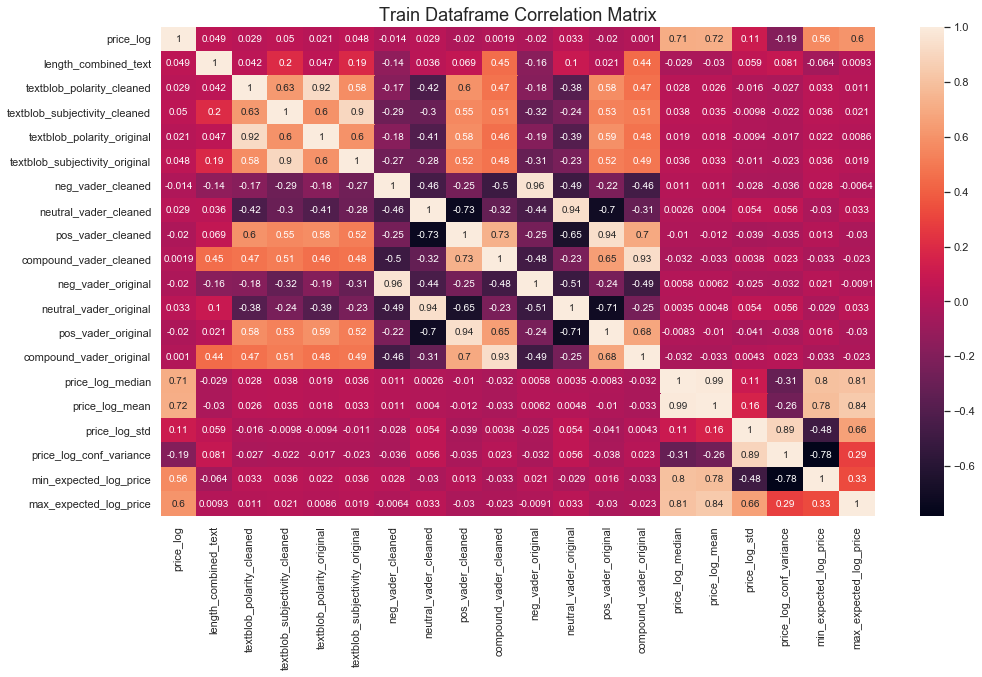

In [48]:
corrMatrix = df_train_corr.corr()
plt.title('Train Dataframe Correlation Matrix', fontsize = 18)
sns.heatmap(corrMatrix, annot=True)
plt.show()

From the above plot, we can observe that, for determining the price, historic statistics like mean/median/min_expected/max_expected price of the group formed by category, brand, shipping and item condition id are most important (correlation with target variable is 0.71 and 0.72 resp.).

However, these price statistics are highly correlated within themselves and hence we should choose only one of these if we build a linear model. In case of tree based models, we can choose top 2 or 3 of them.

### Checking the same for CV data as a sanity check

In [49]:
df_cv_corr = df_cv.drop(columns =  ['train_id',
                                    'item_condition_id',
                                    'shipping',
                                    'price'])

In [50]:
df_cv_corr['price_log_median'] = (df_cv_corr['price_log_median'] - np.mean(df_cv_corr['price_log_median']))/np.std(df_cv_corr['price_log_median'])
df_cv_corr['price_log_mean'] = (df_cv_corr['price_log_mean'] - np.mean(df_cv_corr['price_log_mean']))/np.std(df_cv_corr['price_log_mean'])
df_cv_corr['price_log_std'] = (df_cv_corr['price_log_std'] - np.mean(df_cv_corr['price_log_std']))/np.std(df_cv_corr['price_log_std'])
df_cv_corr['price_log_conf_variance'] = (df_cv_corr['price_log_conf_variance'] - np.mean(df_cv_corr['price_log_conf_variance']))/np.std(df_cv_corr['price_log_conf_variance'])
df_cv_corr['min_expected_log_price'] = (df_cv_corr['min_expected_log_price'] - np.mean(df_cv_corr['min_expected_log_price']))/np.std(df_cv_corr['min_expected_log_price'])
df_cv_corr['max_expected_log_price'] = (df_cv_corr['max_expected_log_price'] - np.mean(df_cv_corr['max_expected_log_price']))/np.std(df_cv_corr['max_expected_log_price'])
df_cv_corr['price_log'] = (df_cv_corr['price_log'] - np.mean(df_cv_corr['price_log']))/np.std(df_cv_corr['price_log'])
df_cv_corr['length_combined_text'] = (df_cv_corr['length_combined_text'] - np.mean(df_cv_corr['length_combined_text']))/np.std(df_cv_corr['length_combined_text'])

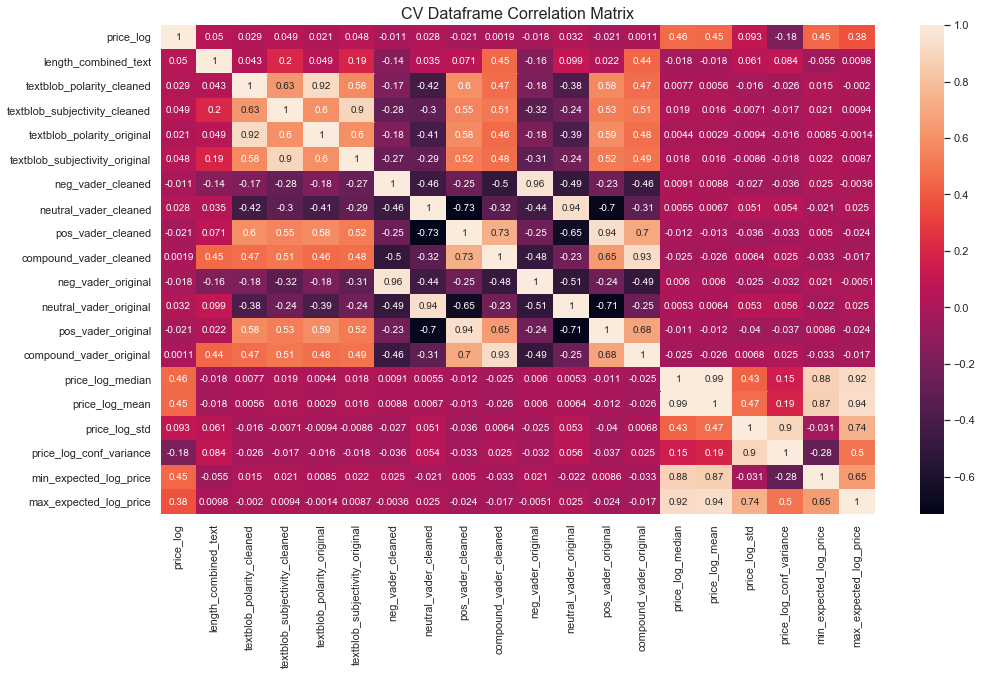

In [51]:
corrMatrix = df_cv_corr.corr()
plt.title('CV Dataframe Correlation Matrix', fontsize = 16)
sns.heatmap(corrMatrix, annot=True)
plt.show()

Correlation between price and price_statistics is still reasonable which means the code is working as expected

### Feature Selection using SelectKBest

We confirm our analysis through SelectKBest tool of sklearn which is another popular feature selection tool available

In [52]:
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'price_log', 'text',
       'length_combined_text', 'item_description_cleaned',
       'textblob_polarity_cleaned', 'textblob_subjectivity_cleaned',
       'textblob_polarity_original', 'textblob_subjectivity_original',
       'neg_vader_cleaned', 'neutral_vader_cleaned', 'pos_vader_cleaned',
       'compound_vader_cleaned', 'neg_vader_original',
       'neutral_vader_original', 'pos_vader_original',
       'compound_vader_original', 'price_log_median', 'price_log_mean',
       'price_log_std', 'price_log_conf_variance', 'min_expected_log_price',
       'max_expected_log_price'],
      dtype='object')

In [53]:
price_log = df_train['price_log']
df_feature_selector = df_train.drop(columns = ['train_id',
                                               'name',
                                               'item_condition_id',
                                               'category_name',
                                               'brand_name',
                                               'price',
                                               'shipping',
                                               'item_description',
                                               'price_log',
                                               'text',
                                               'item_description_cleaned',                                               
                                               'neg_vader_cleaned',
                                               'neutral_vader_cleaned',
                                               'pos_vader_cleaned',
                                               'neg_vader_original',
                                               'neutral_vader_original',
                                               'pos_vader_original'])

In [54]:
df_feature_selector.columns

Index(['length_combined_text', 'textblob_polarity_cleaned',
       'textblob_subjectivity_cleaned', 'textblob_polarity_original',
       'textblob_subjectivity_original', 'compound_vader_cleaned',
       'compound_vader_original', 'price_log_median', 'price_log_mean',
       'price_log_std', 'price_log_conf_variance', 'min_expected_log_price',
       'max_expected_log_price'],
      dtype='object')

In [55]:
price_log = (price_log - np.mean(price_log))/np.std(price_log)

In [56]:
df_feature_selector['price_log_median'] = (df_feature_selector['price_log_median'] - np.mean(df_feature_selector['price_log_median']))/np.std(df_feature_selector['price_log_median'])
df_feature_selector['price_log_mean'] = (df_feature_selector['price_log_mean'] - np.mean(df_feature_selector['price_log_mean']))/np.std(df_feature_selector['price_log_mean'])
df_feature_selector['price_log_std'] = (df_feature_selector['price_log_std'] - np.mean(df_feature_selector['price_log_std']))/np.std(df_feature_selector['price_log_std'])
df_feature_selector['price_log_conf_variance'] = (df_feature_selector['price_log_conf_variance'] - np.mean(df_feature_selector['price_log_conf_variance']))/np.std(df_feature_selector['price_log_conf_variance'])
df_feature_selector['min_expected_log_price'] = (df_feature_selector['min_expected_log_price'] - np.mean(df_feature_selector['min_expected_log_price']))/np.std(df_feature_selector['min_expected_log_price'])
df_feature_selector['max_expected_log_price'] = (df_feature_selector['max_expected_log_price'] - np.mean(df_feature_selector['max_expected_log_price']))/np.std(df_feature_selector['max_expected_log_price'])
df_feature_selector['length_combined_text'] = (df_feature_selector['length_combined_text'] - np.mean(df_feature_selector['length_combined_text']))/np.std(df_feature_selector['length_combined_text'])
df_feature_selector['length_combined_text'] = (df_feature_selector['length_combined_text'] - np.mean(df_feature_selector['length_combined_text']))/np.std(df_feature_selector['length_combined_text'])

In [57]:
selector = SelectKBest(f_regression, k = "all")
selector.fit(df_feature_selector, price_log)
for feature, score in zip(df_feature_selector.columns, selector.scores_):
    print("Feature: ", feature, "\nScore:   ", round(score), "\n")

Feature:  length_combined_text 
Score:    2707.0 

Feature:  textblob_polarity_cleaned 
Score:    917.0 

Feature:  textblob_subjectivity_cleaned 
Score:    2757.0 

Feature:  textblob_polarity_original 
Score:    499.0 

Feature:  textblob_subjectivity_original 
Score:    2583.0 

Feature:  compound_vader_cleaned 
Score:    4.0 

Feature:  compound_vader_original 
Score:    1.0 

Feature:  price_log_median 
Score:    1132773.0 

Feature:  price_log_mean 
Score:    1181959.0 

Feature:  price_log_std 
Score:    14428.0 

Feature:  price_log_conf_variance 
Score:    41485.0 

Feature:  min_expected_log_price 
Score:    516510.0 

Feature:  max_expected_log_price 
Score:    641104.0 



From here also, we get the same observation, the historical price statistics features are the most important ones in determining the price of new item and hence we select 3 of these: price_log_meidan, min_expected_log_price and max_expected_log_price as additional features for building our ML models

#### The rest of the featurizations, specific to text, like TF-IDF, dense vectors etc. will be done as and when required for particular models